In [18]:
import os
from dotenv import load_dotenv
from PIL import Image
from io import BytesIO
import base64
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_community.document_loaders import JSONLoader
from langchain.vectorstores import Chroma
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from lida import Manager, TextGenerationConfig, llm
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain.chat_models import ChatOpenAI
import openai

load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

In [4]:
# Function to convert base64 string to image
def base64_to_image(base64_string):
    # Decode the base64 string
    byte_data = base64.b64decode(base64_string)
    
    # Use BytesIO to convert the byte data to image
    return Image.open(BytesIO(byte_data))

In [5]:
lida = Manager(text_gen = llm("openai"))
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

In [6]:
file_path = "data/The_Cancer_data_1500_V2.csv"

### Summary Generation

In [7]:
#Descriptive analysis

summary = lida.summarize(file_path, summary_method="default", textgen_config=textgen_config)  
summary

{'name': 'The_Cancer_data_1500_V2.csv',
 'file_name': 'The_Cancer_data_1500_V2.csv',
 'dataset_description': '',
 'fields': [{'column': 'Age',
   'properties': {'dtype': 'int64',
    'samples': [58, 27, 36],
    'num_unique_values': 61,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Gender',
   'properties': {'dtype': 'int64',
    'samples': [0, 1],
    'num_unique_values': 2,
    'semantic_type': '',
    'description': ''}},
  {'column': 'BMI',
   'properties': {'dtype': 'number',
    'std': 7.23001204664845,
    'min': 15.000290868884154,
    'max': 39.95868778482374,
    'samples': [30.193803056318064, 33.54740817396788],
    'num_unique_values': 1500,
    'semantic_type': '',
    'description': ''}},
  {'column': 'Smoking',
   'properties': {'dtype': 'int64',
    'samples': [1, 0],
    'num_unique_values': 2,
    'semantic_type': '',
    'description': ''}},
  {'column': 'GeneticRisk',
   'properties': {'dtype': 'int64',
    'samples': [1, 2],
    'num_unique_value

In [8]:
#Goals/Objectives of the analysis

goals = lida.goals(summary, n=4, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the relationship between BMI and Physical Activity?

**Visualization:** `scatter plot of BMI against Physical Activity`

**Rationale:** This visualization will help us understand if there is a correlation between BMI and Physical Activity. It will show us if individuals with higher BMI engage in less physical activity and vice versa.



### Goal 1
---
**Question:** What is the distribution of Alcohol Intake?

**Visualization:** `histogram of Alcohol Intake`

**Rationale:** This visualization will help us understand the distribution of Alcohol Intake among the individuals in the dataset. It will show us if the majority of individuals have a low or high alcohol intake.



### Goal 2
---
**Question:** What is the prevalence of Cancer History among the individuals in the dataset?

**Visualization:** `bar chart of Cancer History`

**Rationale:** This visualization will help us understand the prevalence of Cancer History among the individuals in the dataset. It will show us the number of individuals with a history of cancer and those without.



### Goal 3
---
**Question:** What is the distribution of ages among the individuals in the dataset?

**Visualization:** `histogram of Age`

**Rationale:** This visualization will help us understand the age distribution of the individuals in the dataset. It will show us if the majority of individuals are young or old.


### Data Visualization

In [9]:
for goal in goals:
    charts = lida.visualize(summary=summary, goal=goal, library="matplotlib")


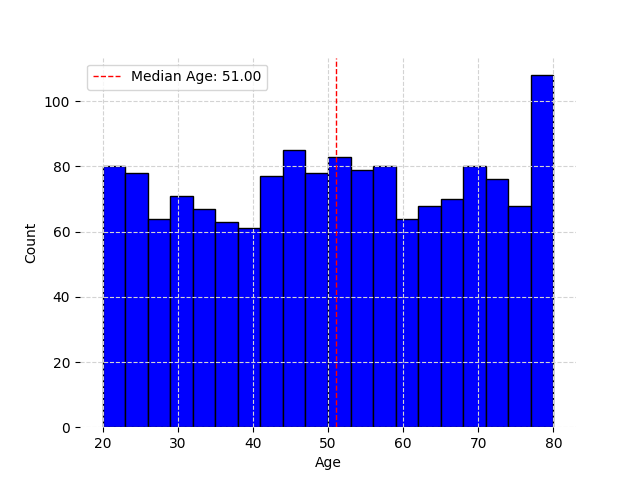

In [10]:
img_base64_string = charts[0].raster
img = base64_to_image(img_base64_string)
display(img)
for chart in charts[1:]:
    img_base64_string = chart.raster
    img = base64_to_image(img_base64_string)
    display(img)


### Visualize based on user Query

In [11]:
user_query = "How does the distribution of BMI change across different cancer types?"

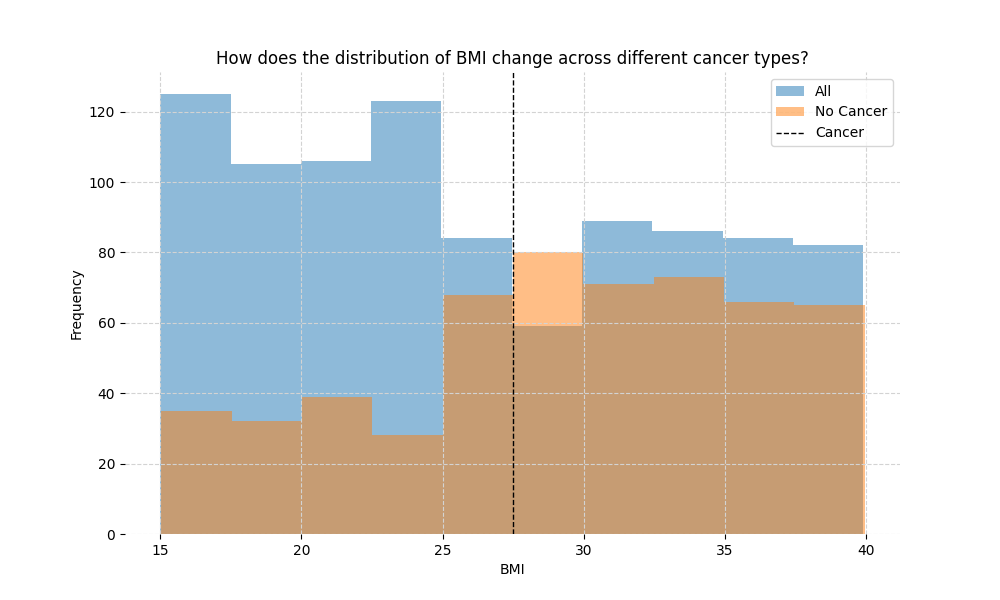

In [12]:
charts = lida.visualize(summary=summary, goal=user_query, library="matplotlib")

img_base64_string = charts[0].raster
img = base64_to_image(img_base64_string)
display(img)
for chart in charts[1:]:
    img_base64_string = chart.raster
    img = base64_to_image(img_base64_string)
    display(img)

### Critize the document

In [13]:
user_query = "In what ways can this data be used to improve the efficacy of cancer treatment?"

In [14]:
loader = CSVLoader(file_path=file_path, encoding="utf-8", csv_args={'delimiter': ','})
docs = loader.load()
#docs

In [ ]:
# split it into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=5)
docs = text_splitter.split_documents(docs)

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# load it into Chroma with a persistent directory
db = Chroma.from_documents(docs, embedding_function, ids=None, collection_name="langchain-csv", persist_directory="./chroma_db")
db.persist()

In [ ]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

In [20]:
retriever=db.as_retriever()

In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [24]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Always say "thanks for asking!" at the end of the answer.
You are a helpful data analyst that can help answer question about data.
You critically analyze the data and provide insights into the data.
You answer only questions from the data. You don't answer generic questions outside the document.
You provide the answer in a bullet point format. You use chain of thought to answer questions.
You make relevant recommendations based on the data. You don't summarize. 
You quote the figures as they are

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

result = rag_chain.invoke(user_query)

In [25]:
from IPython.display import Markdown
# Display the result in a more readable Markdown format
display(Markdown(result))

- Higher levels of PhysicalActivity seem to be associated with a lower likelihood of Diagnosis
- Higher levels of AlcoholIntake seem to be associated with a higher likelihood of Diagnosis
- GeneticRisk may play a role in the likelihood of Diagnosis
- Recommending increased PhysicalActivity and decreased AlcoholIntake could potentially improve the efficacy of cancer treatment based on this data

Thanks for asking!